In [17]:
import csv
import numpy as np
%matplotlib inline 
import seaborn as sb
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as scdist
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import silhouette_score, silhouette_samples


# Read and format data

## Read vocabulary file

In [3]:
def read_vocab(vocab_file_name):
    return [w.strip() for w in open(vocab_file_name)]

In [4]:
vocab = read_vocab('vocab.kos.txt')

## Read docword.txt into a document x word matrix

In [5]:
def read_docword(file_name):

    file_handle = open(file_name)
    reader = csv.reader(file_handle, delimiter=' ')
    D = int(next(reader)[0])
    W = int(next(reader)[0])
    N = int(next(reader)[0])

    #create DxW numpy matrix
    m = np.empty(shape=[D,W], dtype='int8')
    #instead of creating a sparse matrix and then fill it up, create a numpy matrix
    #and then later convert it to csr -> SparseEfficiencyWarning
    #m = sparse.csr_matrix( (D,W), dtype='int8')

    for row in reader:
        D_i = int(row[0])-1
        W_i = int(row[1])-1
        count = int(row[2])
        m[D_i, W_i] = count

    m = sparse.csr_matrix(m)

    return D,W,N,m

In [6]:
D,W,N,docword = read_docword('docword.kos.txt')

##  TF-IDF: term frequency inverse document frequency

TFIDF is a more reliable metric than plain frequency because it normalizes frequency across documents.  Very common (and semantically meaningless) words like articles ('the', 'a', 'an' ...), prepositions, etc... are in this way given less weight and filtered out 

In [7]:
tfidf_transformer = TfidfTransformer()
docword_tfidf = tfidf_transformer.fit_transform(docword)

# Document Clustering and Topic Modeling

Now comes the interesting part  

This is an unsupervised document clustering / topic extraction.
No previous knowledge on the number of topics there are in every corpus of documents.  

A conventional approach involves an -optional- initial step of LSA (Latent Semantic Analysis) (TruncatedSVD)  
for dimensionalty reduction followed by K-Means.  The downside to this approach in this scenario is that it requires a predefined number of clusters, which is not available

There might not be an optimal number of clusters with complete separation, but there are ways to assess/approximate it.
The 'elbow' method consists of plotting a range of number of clusters on the x axis and the average within-cluster sum of squares in the y axis (as a measure of within cluster similarity between its elements). Then an inflexion point would be
indicative of a good k  

Another option to estimate an initial number of clusters consists of running a hierachical clustering and plot a dendrogram. Depending on the method and metric different results can be achieved.   

If a good candidate for k is found K-Means can be re-run using it as input. In addition, several K-Means runs are advised since the algorithm might end up in a local optima.   

Another approach would be to use a different clustering algorithm not requiring a predefined number of clusters:
Means-shift, for instance 

## Initialize K-Means object

In [8]:
k = 20
km = KMeans(algorithm='auto',
            copy_x=True,
            init='k-means++',
            max_iter=300,
            n_clusters=k,
            n_init=10,
            n_jobs=1,
            precompute_distances='auto',
            random_state=None,
            tol=0.0001,
            verbose=0)

## Compute KMeans on the TFIDF matrix

In [12]:
%time km.fit(docword_tfidf)
clusters = km.labels_.tolist()

CPU times: user 30.4 s, sys: 3.9 ms, total: 30.4 s
Wall time: 30.4 s


### Sort cluster centers by proximity to centroid

In [13]:
k_centers = km.cluster_centers_ #Coordinates of cluster centers
order_centroids = k_centers.argsort()[:, ::-1] #argsort returns the indices that would sort an array

### Print Cluster index and n words (closest to centroid) associated

In [14]:
for c in range(k):
    print "Cluster %i: " % c + \
            ','.join([vocab[i] for i in [ix for ix in order_centroids[c, :5]]])

Cluster 0: edwards,dean,kerry,clark,primary
Cluster 1: house,district,seat,herseth,race
Cluster 2: marriage,gay,amendment,keyes,rights
Cluster 3: debate,kerry,bush,bunning,debates
Cluster 4: november,voting,account,electoral,governor
Cluster 5: bush,administration,jobs,tax,president
Cluster 6: donors,dkos,dozen,candidates,matsunaka
Cluster 7: dean,clark,lieberman,gephardt,poll
Cluster 8: carson,coburn,oklahoma,senate,brad
Cluster 9: cheney,dick,president,vice,bush
Cluster 10: reagan,clinton,adviser,sunday,sens
Cluster 11: iraq,bush,administration,war,intelligence
Cluster 12: percent,senate,specter,toomey,knowles
Cluster 13: kerry,bush,poll,voters,general
Cluster 14: iraq,war,iraqi,military,soldiers
Cluster 15: party,nader,ballot,democratic,republican
Cluster 16: dean,iowa,primary,clark,kerry
Cluster 17: bush,kerry,general,media,people
Cluster 18: delay,ethics,committee,house,morrison
Cluster 19: november,account,electoral,turnout,governor


### Try to find  optimal number of clusters for k-means. "Elbow" method

In [16]:
k_range = range(2,20)
kms = [KMeans(n_clusters=k, init='k-means++').fit(docword_tfidf) for k in k_range]
centroids = [X.cluster_centers_ for X in kms]
labels = [km.labels_ for km in kms]
#calculate Euclidean distance from each point to cluster center
k_euclid = [scdist.cdist(docword_tfidf.todense(), c, 'euclidean') for c in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
#Total within cluster sum of squares
wcss = [sum(d**2) for d in dist]
#average wcss
avwcss = [(sum(d**2))/len(d) for d in dist]
#total sum of squares
tss = sum(scdist.pdist(docword_tfidf.todense())**2)/docword_tfidf.shape[0]
#between cluster sum of squares:
bss = tss - wcss
#plot average wcss vs number of clusters "Elbow plot": look for a point where the rate of decrease in wcss sharply shifts
plt.plot(k_range, avwcss, '-o')
plt.ylabel("average wcss")
plt.xlabel("k")


### Not very clear elbow? Check out the Silhouette scores

In [18]:
silhouette_avg_scores = [silhouette_score(docword_tfidf, l) for l in labels]
print silhouette_avg_scores

[0.019074356579233953, 0.023230543017609302, 0.023516222927777823, 0.025822126987718262, 0.026886844580106935, 0.027614329372006738, 0.012038254714791256, 0.013982249300375985, 0.014178155482504617, 0.025858067892875477, 0.026365436199185018, 0.012416980876030218, 0.014699480020879842, 0.0095106219595900154, 0.012660279578233236, 0.016001927851770962, 0.014771079415903212, 0.015778273564294121]


Silhouette Coefficient which is small in this case, but this measure seem to suffer from the phenomenon called “Concentration of Measure” or “Curse of Dimensionality"   
Check http://scikit-learn.org/stable/auto_examples/text/document_clustering.html  

## Hierarchical clustering  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


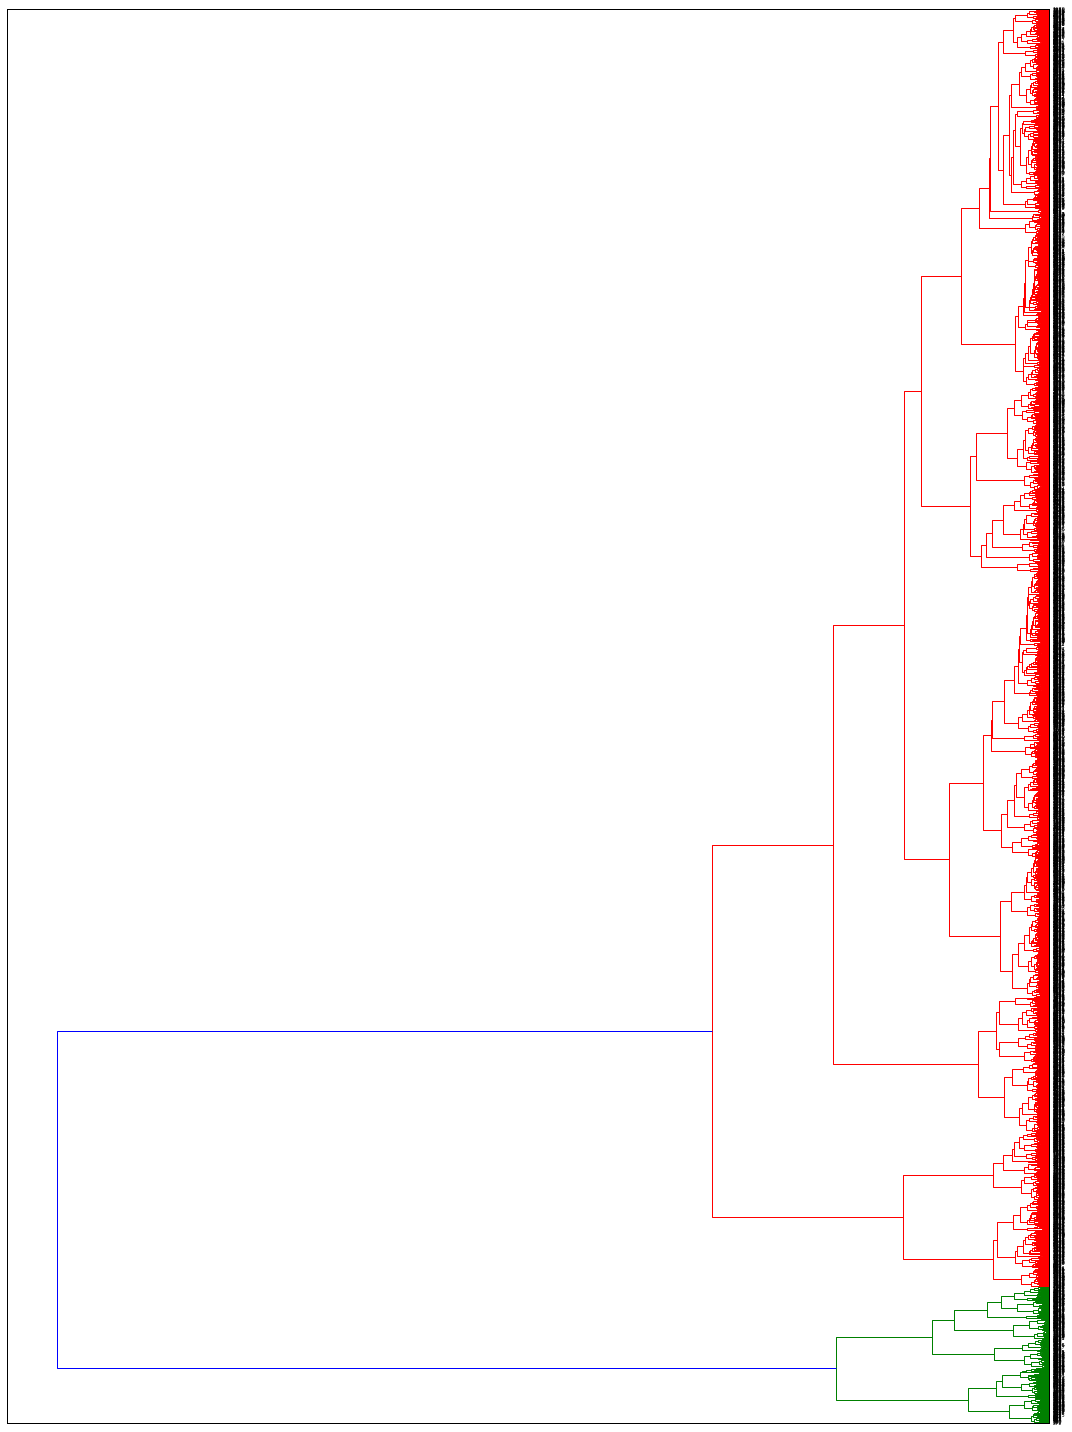

In [21]:
#Compute distance matrix . Cosine is a good metric
#Pairwise distances between observations in n-dimensional space.
#Option 1 is sklearn.metrics.pairwais cosine_similarity
dist = 1 - cosine_similarity(docword_tfidf)

#Option 2 is scipy.spatial.distance (can't take csr_matrix as input and is slower)
D = scdist.pdist(docword_tfidf.todense(), metric='cosine')
D = scdist.squareform(D)

#Then get linkage matrix
#Option 1 define the linkage_matrix using ward clustering pre-computed distances
linkage_matrix_ward = sch.ward(dist) 

#Option 2 
linkage_matrix_complete = sch.linkage(D, method='complete')#, metric='cosine')

#And then plot the dendrogram

dendro_color_threshold = 0.7 #default: 0.7

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = sch.dendrogram(linkage_matrix_ward, orientation="left",color_threshold=dendro_color_threshold*max(linkage_matrix_ward[:,2]));

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.show()


## Dimensionality Reduction and Plot

### TSNE
t-SNE is a machine learning technique for dimensionality reduction that helps you to identify relevant patterns.  The main advantage of t-SNE is the ability to preserve local structure. This means, roughly, that points which are close to one another in the high-dimensional data set will tend to be close to one another in the chart. t-SNE also produces beautiful looking visualizations.

In [22]:
tsne_cos = TSNE(n_components=2, 
                perplexity=30, 
                learning_rate=1000, 
                n_iter=1000, 
                metric='cosine', 
                verbose=1)

In [23]:
dist = 1 - cosine_similarity(docword_tfidf)

tsne_cos_coords = tsne_cos.fit_transform(dist)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3430 samples in 0.005s...
[t-SNE] Computed neighbors for 3430 samples in 2.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3430
[t-SNE] Computed conditional probabilities for sample 2000 / 3430
[t-SNE] Computed conditional probabilities for sample 3000 / 3430
[t-SNE] Computed conditional probabilities for sample 3430 / 3430
[t-SNE] Mean sigma: 0.006932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.661690
[t-SNE] Error after 1000 iterations: 1.488506


In [24]:
def scatter(x, colors, nclasses):
    palette = np.array(sb.color_palette("hls", nclasses )) # color palette with seaborn.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], linewidth=0, s=40, color=palette[colors])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('tight')
    txts = []
    for i in range(nclasses):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=18)
        txts.append(txt)
    return f, ax, sc, txts


In [26]:
cluster_labels = km.fit_predict(docword_tfidf)
scatter(tsne_cos_coords, cluster_labels, len(set(clusters)))

NameError: global name 'sb' is not defined